In [1]:
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.config import DATASET_PATH
from torch.utils.data import DataLoader
import os

from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
import numpy as np

from snn_delays.snn_refactored import SNN
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

'''
3-letter classification dataset (permuted without repetition)

in total, 6 classes

'''

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data = np.load(os.path.join(DATASET_PATH, 'Letters', 'three_permuted_letter_classification_dataset.npz'))

train_data = data['train_data']
test_data = data['test_data']
train_labels= data['train_labels']
test_labels = data['test_labels']

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')
batch_size = 128

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["time_ms"] = 1e3
dataset_dict["dataset_name"] = "letters"

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
Initializing GPU cache for 2400 samples...
Cache initialized in 0.41 seconds
Initializing GPU cache for 600 samples...
Cache initialized in 0.01 seconds
num timesteps per sample: 48


In [2]:
num_h = 64

time_window = 48

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=6, bias=False)
    )
  )
)

In [3]:
ckpt_dir = 'permuted_3letters_task'
num_epochs = 50

lr_tau = 0.1

train(snn_f, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rnn, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rd, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)

Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [6/18], Loss: 5.96828
Step [12/18], Loss: 4.88702
Step [18/18], Loss: 4.15457
Time elasped: 3.739370584487915
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.94449
Step [12/18], Loss: 2.19912
Step [18/18], Loss: 2.17058
Time elasped: 2.7312891483306885
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.91721
Step [12/18], Loss: 1.88370
Step [18/18], Loss: 1.96589
Time elasped: 2.9363818168640137
Epoch [4/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.80755
Step [12/18], Loss: 1.80733
Step [18/18], Loss: 1.83278
Time elasped: 2.8818938732147217
Epoch [5/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.83597
Step [12/18], Loss: 1.88128
Step [18/18], Loss: 1.78637
Time elasped: 2.9021527767181396
600
Test Loss: 1.8801026105880738
Avg spk_count per neuron for all 48 time-steps 274.55
Test Accuracy of the model on the test samples: 18.833

max acc: 18.833333333333332
Epoch [6/50], learning_rates 0.001000, 0.100000
Step [6/1

Extra: vanilla feedforward

In [4]:
snn_vf = SNN(dataset_dict, structure=(num_h, 2, 'f'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_vf.set_layers()
snn_vf.to(device)

train(snn_vf, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 6.57291
Step [12/18], Loss: 3.69521
Step [18/18], Loss: 2.96600
Time elasped: 4.014121055603027
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.42587
Step [12/18], Loss: 2.18721
Step [18/18], Loss: 1.95836
Time elasped: 3.915921926498413
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.94330
Step [12/18], Loss: 1.82913
Step [18/18], Loss: 1.93528
Time elasped: 3.940260171890259
Epoch [4/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.93108
Step [12/18], Loss: 1.82106
Step [18/18], Loss: 1.79145
Time elasped: 4.08868932723999
Epoch [5/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.82043
Step [12/18], Loss: 1.81347
Step [18/18], Loss: 1.86619
Time elasped: 3.8910629749298096
600
Test Loss: 1.8602568864822

Text(0.5, 1.0, 'train loss')

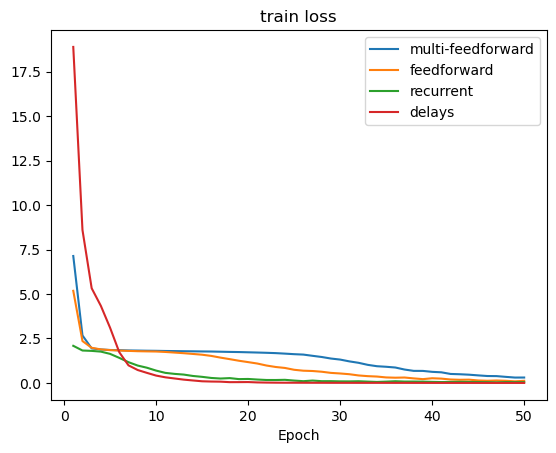

In [5]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')

In [6]:
snn_vf

SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=6, bias=False)
    )
  )
)

In [7]:
snn_rnn.train_loss

[[1, 2.087857125600179],
 [2, 1.823932622273763],
 [3, 1.8027298482259115],
 [4, 1.7619743665059409],
 [5, 1.6351935640970865],
 [6, 1.4103043174743652],
 [7, 1.1682673295338948],
 [8, 0.9783062267303467],
 [9, 0.8568257776896159],
 [10, 0.6955388768513997],
 [11, 0.5676197369893392],
 [12, 0.510527286529541],
 [13, 0.4712709824244181],
 [14, 0.39322263876597086],
 [15, 0.3438321590423584],
 [16, 0.28105186065038046],
 [17, 0.24894813617070516],
 [18, 0.272820717493693],
 [19, 0.21641304969787598],
 [20, 0.22482681035995483],
 [21, 0.1923624551296234],
 [22, 0.16681763807932537],
 [23, 0.16588239828745524],
 [24, 0.17641512910525003],
 [25, 0.13415702521800996],
 [26, 0.09998672048250834],
 [27, 0.1347501556078593],
 [28, 0.10031043271223704],
 [29, 0.10138832410176594],
 [30, 0.08957413633664449],
 [31, 0.08765842566887537],
 [32, 0.09692253778378168],
 [33, 0.07628775815169017],
 [34, 0.05716356684764226],
 [35, 0.07475490788618723],
 [36, 0.09782320052385331],
 [37, 0.07879833380381

In [8]:
snn_vf.train_loss

[[1, 5.179134318033854],
 [2, 2.355198491414388],
 [3, 1.9767610677083334],
 [4, 1.8860708300272624],
 [5, 1.8467414919535319],
 [6, 1.8213798395792644],
 [7, 1.803271001180013],
 [8, 1.7849719746907553],
 [9, 1.7749958292643229],
 [10, 1.7672763061523438],
 [11, 1.7430367596944174],
 [12, 1.7084886741638183],
 [13, 1.673255697886149],
 [14, 1.630889581044515],
 [15, 1.5880102030436198],
 [16, 1.5202373631795247],
 [17, 1.4241863632202147],
 [18, 1.338498617808024],
 [19, 1.2488583056131999],
 [20, 1.171603635152181],
 [21, 1.0921245797475179],
 [22, 0.9795531368255616],
 [23, 0.89759170850118],
 [24, 0.8438084316253662],
 [25, 0.7410118961334229],
 [26, 0.6887799453735352],
 [27, 0.6719475968678792],
 [28, 0.6309633906682333],
 [29, 0.5660245354970296],
 [30, 0.5335494200388591],
 [31, 0.49160233974456785],
 [32, 0.4224276463190714],
 [33, 0.38294689496358236],
 [34, 0.3604045836130778],
 [35, 0.3106522266070048],
 [36, 0.295643793741862],
 [37, 0.30587732235590614],
 [38, 0.256488666

In [9]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_vf.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()
snn_vf.init_state_logger()


# from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
# images, labels_mf = propagate_batch_simple(snn_f, test_loader)
# _, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
# _, labels_rd = propagate_batch_simple(snn_rd, test_loader)

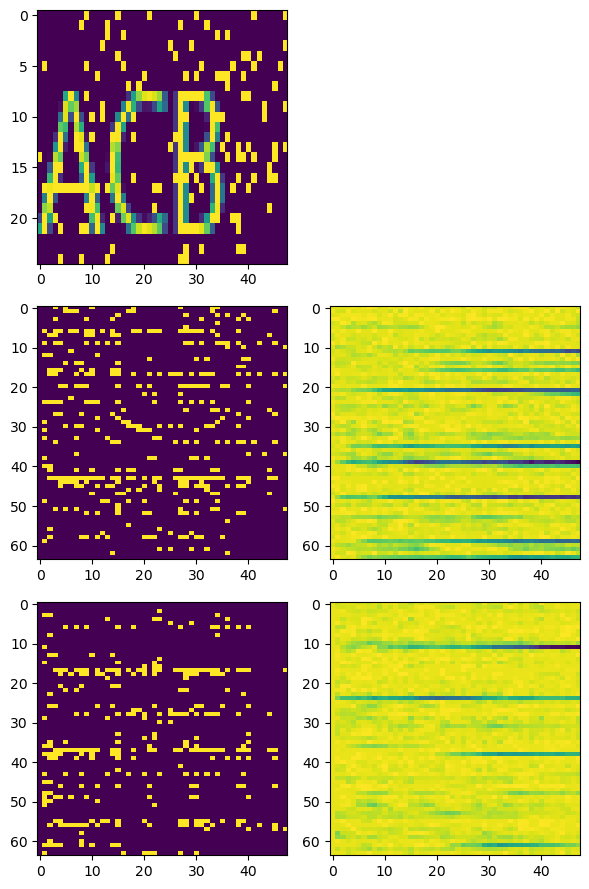

In [10]:
images, _ = propagate_batch_simple(snn_f, test_loader)
spk = snn_f.spike_state
mem = snn_f.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

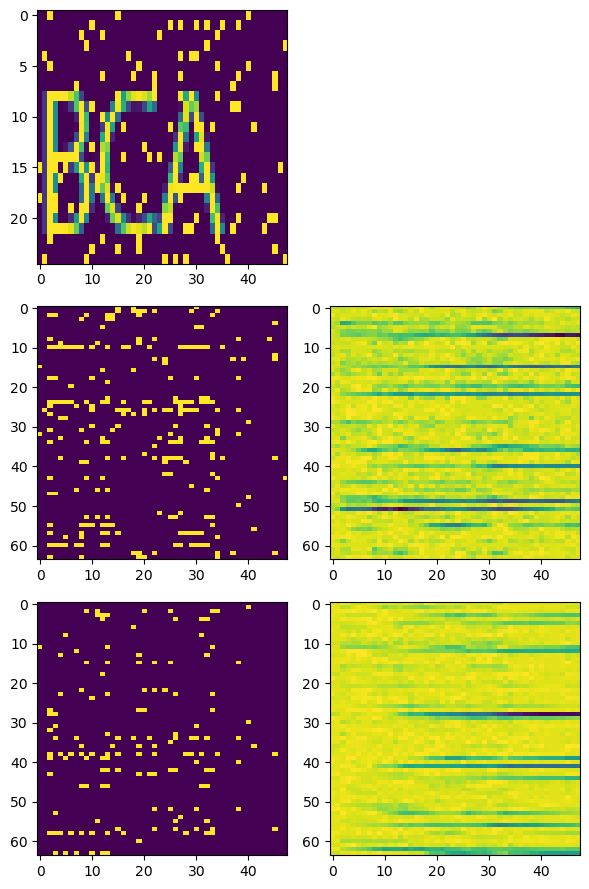

In [11]:
images, _ = propagate_batch_simple(snn_vf, test_loader)
spk = snn_vf.spike_state
mem = snn_vf.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

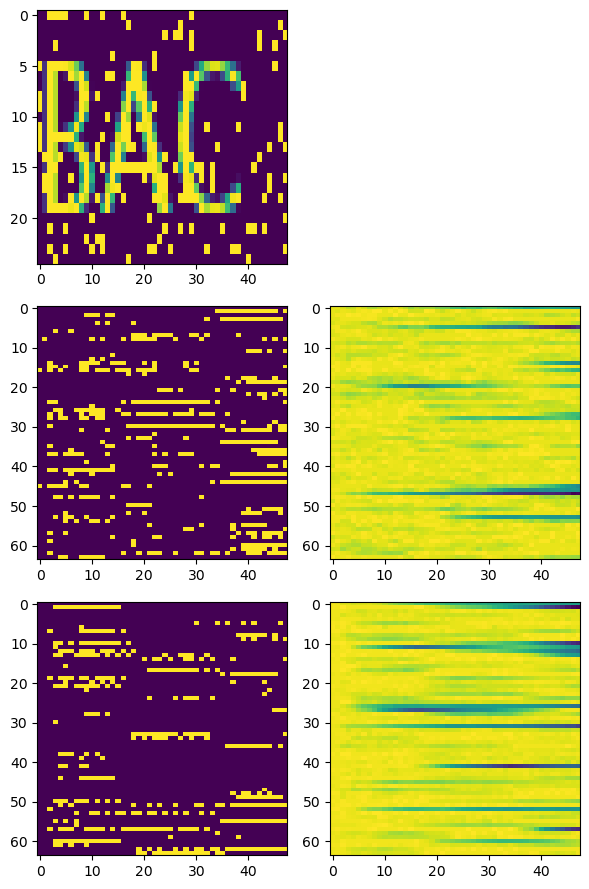

In [12]:
images, _ = propagate_batch_simple(snn_rnn, test_loader)
spk = snn_rnn.spike_state
mem = snn_rnn.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

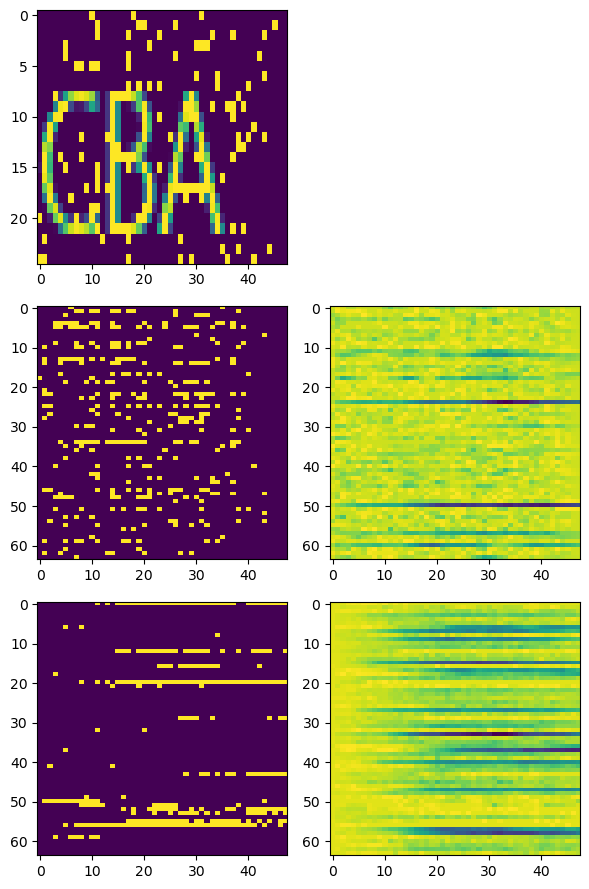

In [13]:
images, _ = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

In [14]:
ckpt_dir = 'permuted_3letters_task'
snn_f.save_model('snn_mf', ckpt_dir)
snn_rnn.save_model('snn_rnn', ckpt_dir)
snn_rd.save_model('snn_rd', ckpt_dir)
snn_vf.save_model('snn_f', ckpt_dir)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task


In [15]:
from snn_delays.utils.model_loader_refac import ModelLoader
ckpt_dir = 'permuted_3letters_task'
snn_vf = ModelLoader('snn_f', ckpt_dir, 128, 'cuda')
snn_mf = ModelLoader('snn_mf', ckpt_dir, 128, 'cuda')
snn_rnn = ModelLoader('snn_rnn', ckpt_dir, 128, 'cuda')
snn_rd = ModelLoader('snn_rd', ckpt_dir, 128, 'cuda')

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [16]:
a, b = snn_vf.test(test_loader)
a, b = snn_mf.test(test_loader)
a, b = snn_rnn.test(test_loader)
a, b = snn_rd.test(test_loader)

600
Test Loss: 4.660902404785157
Avg spk_count per neuron for all 48 time-steps 223.5825
Test Accuracy of the model on the test samples: 45.000

600
Test Loss: 4.292056274414063
Avg spk_count per neuron for all 48 time-steps 285.34166666666664
Test Accuracy of the model on the test samples: 44.667

600
Test Loss: 1.858696985244751
Avg spk_count per neuron for all 48 time-steps 300.18083333333334
Test Accuracy of the model on the test samples: 60.500

600
Test Loss: 3.068636894226074
Avg spk_count per neuron for all 48 time-steps 316.2558333333333
Test Accuracy of the model on the test samples: 58.000



Text(0.5, 1.0, 'train loss')

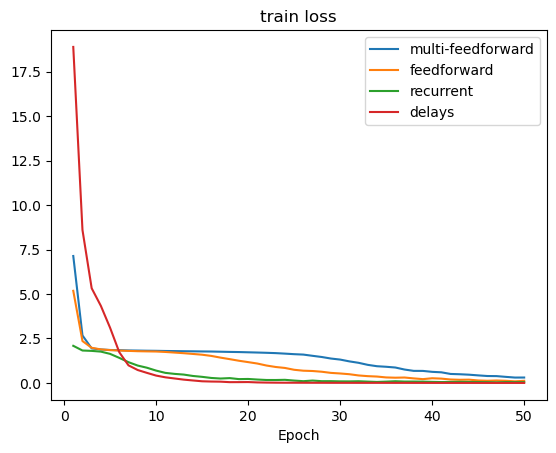

In [17]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_mf.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')

Text(0.5, 1.0, 'train loss')

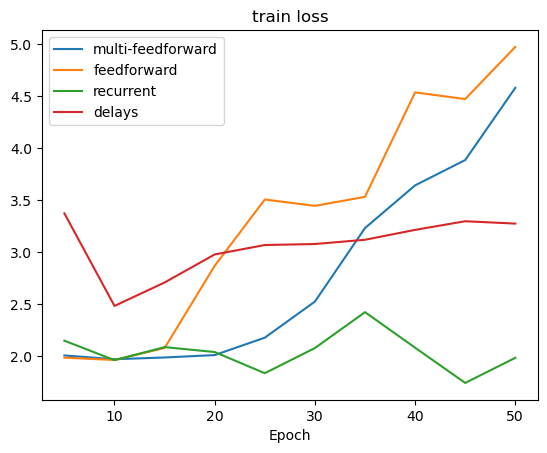

In [18]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_mf.test_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.test_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.test_loss, label = 'recurrent')
plot_per_epoch(snn_rd.test_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')